In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load datasets
kal_data = pd.read_excel('/Users/berhe/Desktop/ka-project/KA_linelist/ll_ka.xlsx')                              # Linelist data 
climate_data = pd.read_csv('/Users/berhe/Desktop/ka-project/Temp-rain-humid/NASA-Temp-perc-humid.csv')          # Rainfall data can e dropped
ndvi_data_16d = pd.read_csv('/Users/berhe/Desktop/ka-project/NDVI_Dataset/MODIS_NDVI_Lankien.csv')              # biweekly NDVI data                     
lst_data = pd.read_csv('/Users/berhe/Desktop/ka-project/MODIS_LST_Dataset/MODIS_LST_Lankien.csv')               # land surface temprature 
perc_data =pd.read_csv('/Users/berhe/Desktop/ka-project/Precipitation_Data/SPI_Lankien.csv')                    # better quality
soil_mois_data =pd.read_csv('/Users/berhe/Desktop/ka-project/soil_moisture_data.csv')
radiation_data =pd.read_csv('/Users/berhe/Desktop/ka-project/Solar_radiation_Dataset/radiation_Lankien.csv')
wind_data =pd.read_csv('/Users/berhe/Desktop/ka-project/Wind_Data_Dataset/wind_Lankien_20250304.csv')
ndvi_data_5d =pd.read_csv('/Users/berhe/Desktop/ka-project/NDVI_Dataset/fiveday_NDVI_Lankien.csv')
evi_data_16d =pd.read_csv('/Users/berhe/Desktop/ka-project/EVI/EVI_16day_Lankien.csv')
flood_cover = pd.read_csv("flood_cover/lankien_flood_timeseries_2015_2024.csv")

# Flood cover data 
flood_cover["date"] = pd.to_datetime(flood_cover["date"]).dt.date
flood_cover["date"] = pd.to_datetime(flood_cover["date"])

# keep only the maximumof the flooded_area_m2 value
flood_cover = flood_cover.groupby("date", as_index=False).max()

# rename the 5d NDVI column to NDVI_5d
ndvi_data_5d.rename(columns={"NDVI": "NDVI_5d"}, inplace=True)

# Convert date columns
kal_data["date"] = pd.to_datetime(kal_data["date"])
climate_data["date"] = pd.to_datetime(climate_data["date"])
ndvi_data_16d["Date"] = pd.to_datetime(ndvi_data_16d["Date"])
lst_data["Date"] =pd.to_datetime(lst_data["Date"])
perc_data["Date"] =pd.to_datetime(perc_data["Date"])
soil_mois_data["Date"] =pd.to_datetime(soil_mois_data["Date"])
radiation_data["date"] =pd.to_datetime(radiation_data["date"])
wind_data["date"] =pd.to_datetime(wind_data["date"])
ndvi_data_5d["Date"] =pd.to_datetime(ndvi_data_5d["Date"])
evi_data_16d["date"] =pd.to_datetime(evi_data_16d["date"])

# Rename NDVI date column to match others
ndvi_data_16d.rename(columns={"Date": "date"}, inplace=True)
ndvi_data_5d.rename(columns={"Date": "date"}, inplace=True)
lst_data.rename(columns={"Date": "date"}, inplace=True)
perc_data.rename(columns={"Date": "date"}, inplace=True)
soil_mois_data.rename(columns={"Date": "date"}, inplace=True)

# Aggregate KA cases per day
ka_cases_daily = kal_data.groupby("date").size().reset_index(name="ka_cases")

# Merge datasets
merged_df = pd.merge(ka_cases_daily, climate_data, on= "date", how = "right")
merged_df = merged_df.merge(ndvi_data_16d, on="date", how= "left")                # Left join keeps all climate data
merged_df = merged_df.merge(ndvi_data_5d, on="date", how= "left")                # Left join keeps all climate data
merged_df =merged_df.merge(lst_data, on = "date", how = "left")
merged_df =merged_df.merge(perc_data, on = "date", how = "left")
merged_df =merged_df.merge(soil_mois_data, on = "date", how = "left")
merged_df =merged_df.merge(radiation_data, on = "date", how = "left")
merged_df =merged_df.merge(wind_data, on = "date", how = "left")
merged_df =merged_df.merge(evi_data_16d, on = "date", how = "left")
merged_df =merged_df.merge(flood_cover, on = "date", how = "left")


# handle the missing values

merged_df["ka_cases"].fillna(0, inplace=True)
merged_df["NDVI"] = merged_df["NDVI"].fillna(method="ffill")
merged_df["Precipitation"] = merged_df["Precipitation"].fillna(method="ffill")
merged_df["SPI"] = merged_df["SPI"].fillna(method="ffill")
merged_df["LST_Day_1km"] = merged_df["LST_Day_1km"].fillna(method="ffill")
merged_df["humidity"] = merged_df["humidity"].fillna(method="ffill")
merged_df["Soil_Moisture"] = merged_df["Soil_Moisture"].fillna(method="ffill")
merged_df["NDVI_5d"] = merged_df["NDVI_5d"].fillna(method="ffill")
merged_df["EVI"] = merged_df["EVI"].fillna(method="ffill")
merged_df["flooded_area_m2"] = merged_df["flooded_area_m2"].fillna(method="ffill")

# Drop rows where 'LST_Day_1km' is missing
merged_df = merged_df.dropna(subset=["LST_Day_1km"])
merged_df = merged_df.dropna(subset=["Soil_Moisture"])
merged_df = merged_df.dropna(subset=["NDVI_5d"])

# filter data to only the period where we have KA cases

# Filter for dates greater than or equal to 2015-11-01
merged_df = merged_df[merged_df["date"] >= "2015-11-01"]
merged_df = merged_df[merged_df["date"] <= "2022-04-05"]

# Display the first few rows of the merged dataset
merged_df.head()

# Check if there are still any missing values
print(merged_df.isnull().sum())

# save the raw data 
merged_df.to_csv("merged_df.csv")

# Feature selection
features = ["temp_mean", "temp_min", "temp_max", "humidity", "NDVI", "NDVI_5d", "Precipitation", "SPI", "LST_Day_1km", "Soil_Moisture", "solar_radiation", "wind_speed_10m", "wind_direction_10m","wind_speed_50m", "wind_direction_50m","EVI", "flooded_area_m2"]
X = merged_df[features]
y = merged_df["ka_cases"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# Create a dictionary to store lagged features
lagged_data = {}

for lag in range(1, 90):  # 60-day lag
    for col in features:
        lagged_data[f"{col}_lag{lag}"] = merged_df[col].shift(lag)

# Convert to DataFrame and concatenate all at once
lagged_df = pd.DataFrame(lagged_data)
merged_df = pd.concat([merged_df, lagged_df], axis=1)

# Drop missing values after lagging
merged_df.dropna(inplace=True)

# Update feature set
lag_features = [col for col in merged_df.columns if "lag" in col]
X = merged_df[lag_features]
y = merged_df["ka_cases"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# XGBoost was best performer 

In [12]:
import optuna
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score

# Ensure data is loaded: X_train, X_test_, y_train, y_test

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 0.5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 10.0),
    }
    
    model = XGBRegressor(**params, random_state=42, n_jobs=-1)
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1)
    
    return -np.mean(scores)  # Convert negative MSE to positive MSE

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Best hyperparameters
best_params_xgb = study.best_params
print("Best XGBoost Params:", best_params_xgb)

# Train final model with best hyperparameters
best_xgb = XGBRegressor(**best_params_xgb, random_state=42, n_jobs=-1)

best_xgb.fit(
    X_train, y_train, 
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Predictions and evaluation
y_pred_xgb = best_xgb.predict(X_test)

# Calculate evaluation metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)  # RMSE Calculation
r2_xgb = r2_score(y_test, y_pred_xgb)

# SMPE Calculation
smpe_xgb = np.mean(2 * np.abs(y_test - y_pred_xgb) / (np.abs(y_test) + np.abs(y_pred_xgb))) * 100

# Print results
print(f"Optimized XGBoost MSE: {mse_xgb:.4f}")
print(f"Optimized XGBoost RMSE: {rmse_xgb:.4f}")
print(f"Optimized XGBoost R² Score: {r2_xgb:.4f}")
print(f"Optimized XGBoost SMPE: {smpe_xgb:.4f}%")


[I 2025-03-24 19:48:57,077] A new study created in memory with name: no-name-c2d4ab28-0e08-4331-93d3-a81fcb2ad645
[I 2025-03-24 19:51:01,380] Trial 0 finished with value: 10.20966276505743 and parameters: {'n_estimators': 700, 'learning_rate': 0.09082113626728813, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.585819450156239, 'colsample_bytree': 0.9766668116105308, 'gamma': 0.05889664545767265, 'reg_lambda': 5.730328706397628, 'reg_alpha': 2.5652497302560753}. Best is trial 0 with value: 10.20966276505743.
[I 2025-03-24 19:55:26,951] Trial 1 finished with value: 10.039196648696812 and parameters: {'n_estimators': 200, 'learning_rate': 0.011114237594916402, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.6147481004028161, 'colsample_bytree': 0.7589575727405711, 'gamma': 0.06737965828212028, 'reg_lambda': 6.850629918669684, 'reg_alpha': 5.7328674794318975}. Best is trial 1 with value: 10.039196648696812.
[I 2025-03-24 20:03:24,963] Trial 2 finished with value: 9.3254729793

Best XGBoost Params: {'n_estimators': 500, 'learning_rate': 0.07184586054213987, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.9743012465955317, 'colsample_bytree': 0.7616526004167103, 'gamma': 0.3170698475770858, 'reg_lambda': 6.120327915204465, 'reg_alpha': 4.026316933949028}
Optimized XGBoost MSE: 12.3847
Optimized XGBoost RMSE: 3.5192
Optimized XGBoost R² Score: 0.3088
Optimized XGBoost SMPE: 115.1967%


# 1️⃣ Model Performance Interpretation & Error Analysis
### Check feature importance: Use best_xgb.feature_importances_ to understand which features drive predictions.

### Residual analysis: Plot residuals (errors) to check for patterns that indicate model bias.

### Distribution of errors: Create histograms or Q-Q plots to verify normality assumptions.
# 2️⃣ Hyperparameter Tuning Refinement
Increase n_trials in Optuna to explore more hyperparameter combinations.

Use pruning (pruner=optuna.pruners.MedianPruner()) to stop underperforming trials early.

Try Bayesian Optimization (Optuna TPE sampler) for smarter hyperparameter searching.

# 3️⃣ Model Generalization Check
Test on an unseen dataset if available (e.g., external validation).

Perform stratified sampling in KFold to ensure balanced data distribution.

Check SHAP values to interpret model predictions.

# 4️⃣ Deployment & Further Experimentation
Save the model (joblib.dump(best_xgb, "xgb_model.pkl")) for reuse.

Convert it to an API if deployment is needed (e.g., Flask/FastAPI).

Compare XGBoost with other models like LightGBM or CatBoost.

# Feature Importance Analysis 

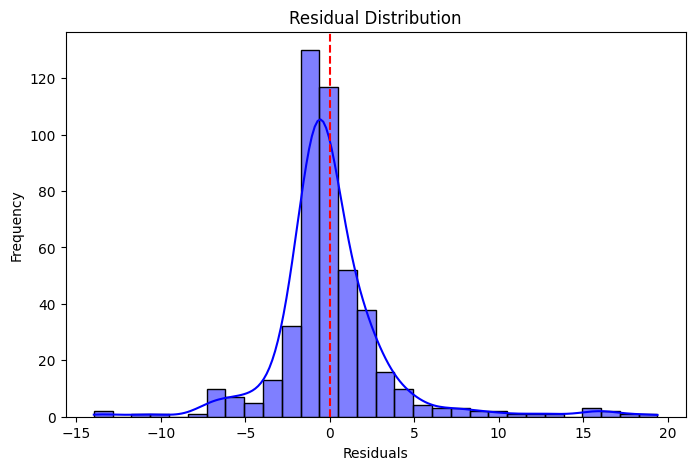

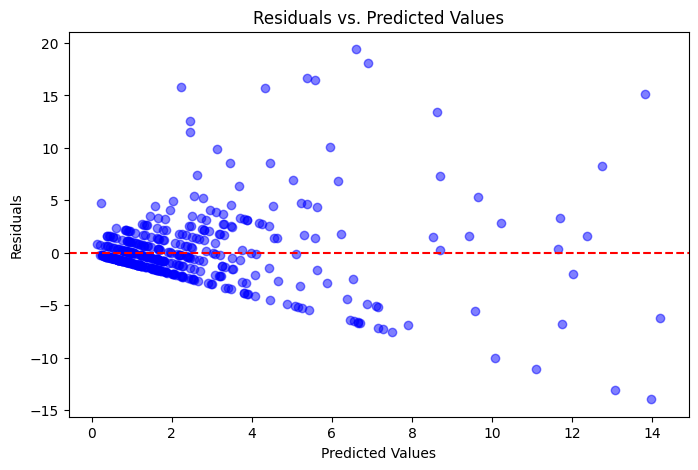

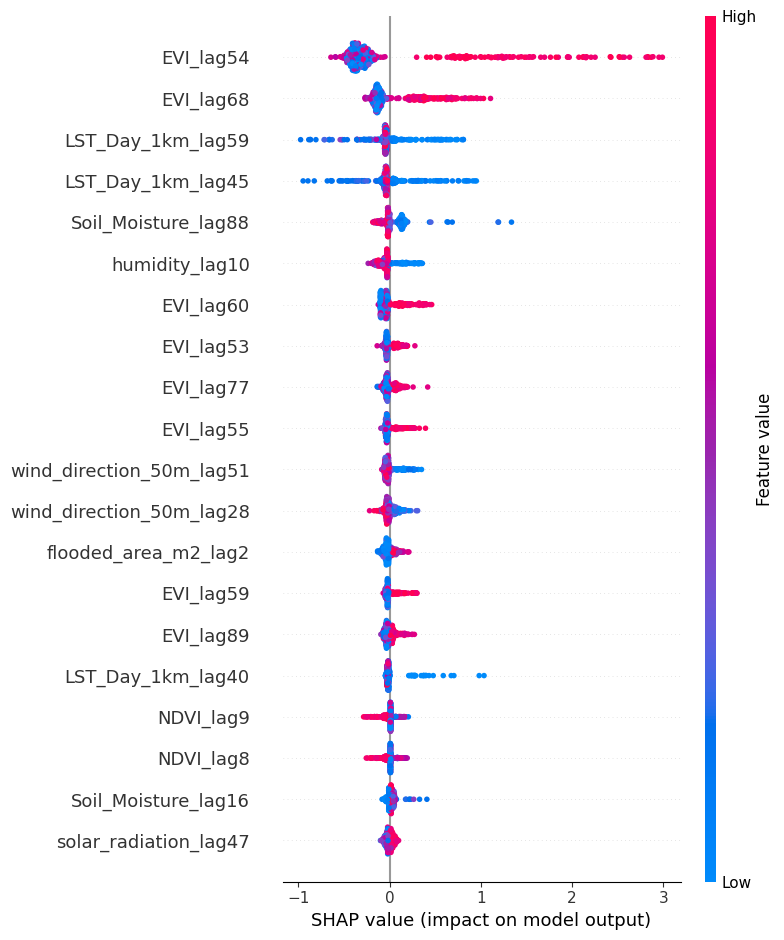

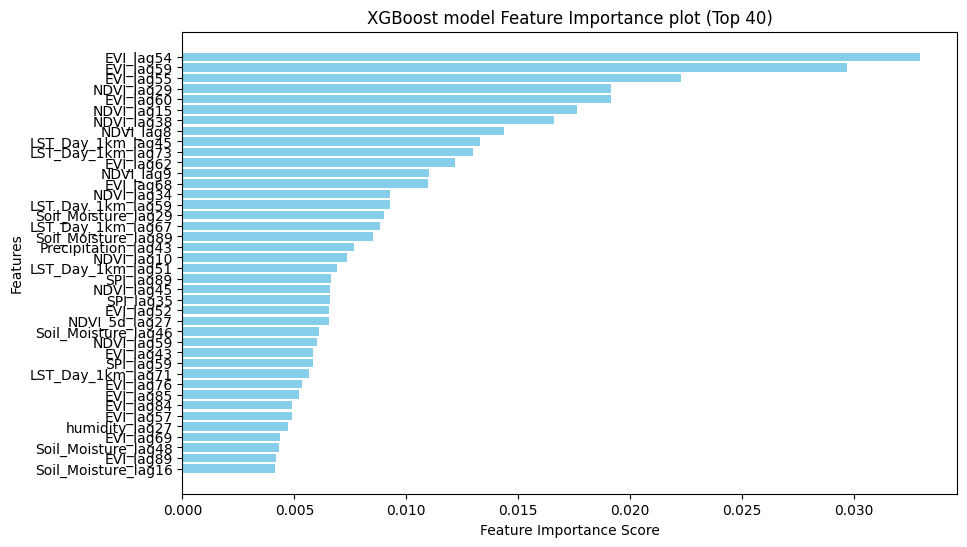

In [48]:
# Residuals plot 

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

residuals = y_test - y_pred_xgb  # Calculate residuals

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

# scatter plot 
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_xgb, residuals, alpha=0.5, color="blue")
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()


# Shap summary plot 
import shap
plt.figure(figsize=(10, 6))
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)



# Ensure feature names are available
feature_names = X.columns  # Save original column names before scaling
# Feature importance
feature_importance = best_xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]  # Sort in descending order
sorted_features = np.array(feature_names)[sorted_idx]  # Use saved column names
# Select **Top 25** Features
top_n = 40  
top_features = sorted_features[:top_n]
top_importance = feature_importance[sorted_idx][:top_n]
# Plot Top 25 Features
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importance, color="skyblue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title(f"XGBoost model Feature Importance plot (Top {top_n})")
plt.gca().invert_yaxis()
plt.show()

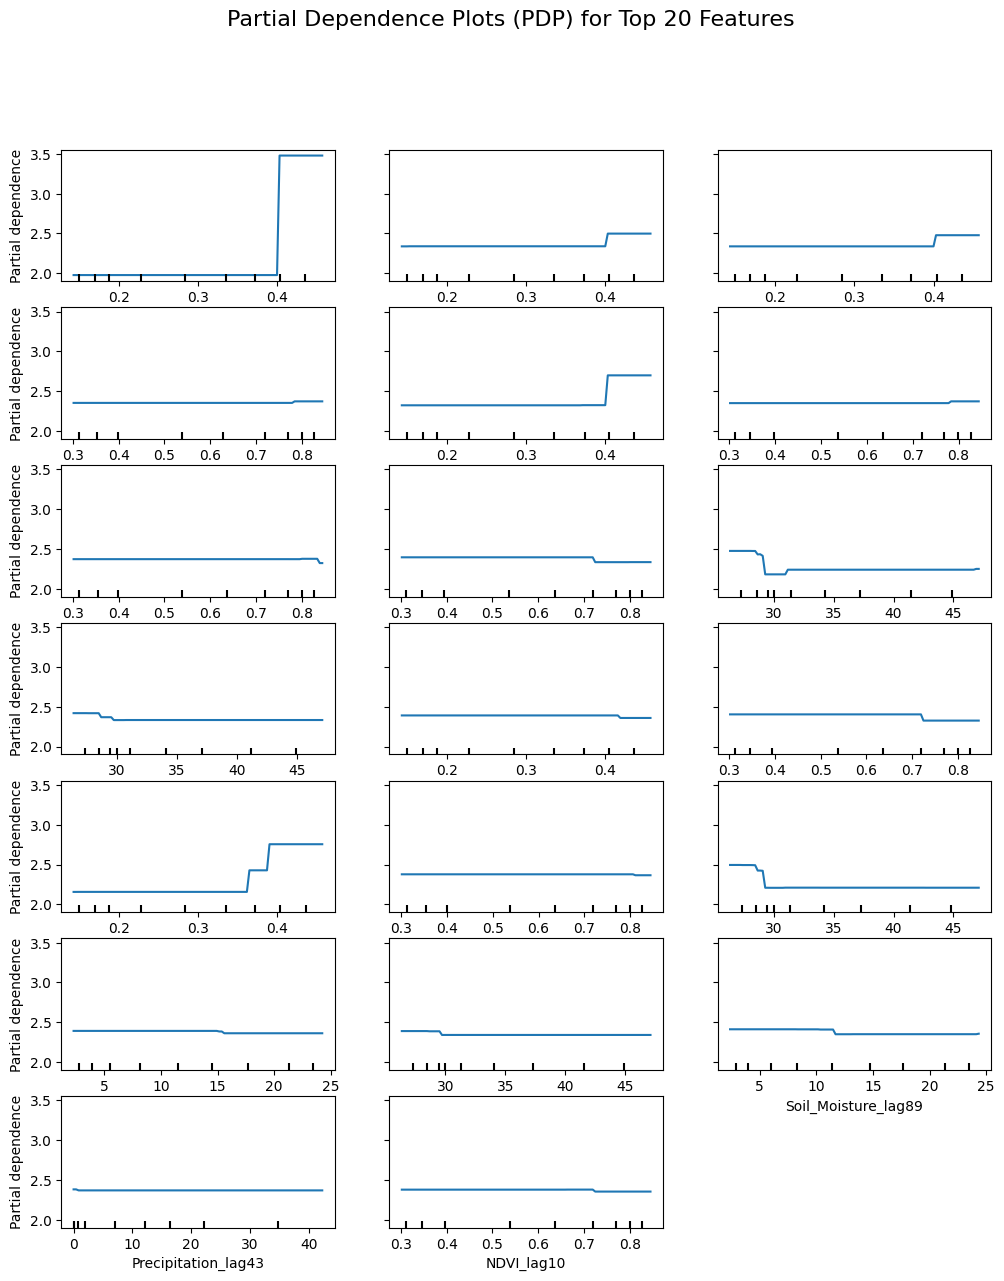

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import shap

# Get feature importance from the XGBoost model
importances = best_xgb.feature_importances_

# Get the feature names from the dataset (assuming it's a DataFrame)
feature_names = X_train.columns

# Create a DataFrame to associate features with their importance scores
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance and get the top 20
top_20_features = importance_df.sort_values(by='Importance', ascending=False).head(20)['Feature'].values

# Generate PDP plots for the top 20 features
fig, ax = plt.subplots(figsize=(12, 14))
PartialDependenceDisplay.from_estimator(best_xgb, X_train, features=top_20_features, ax=ax)
plt.suptitle("Partial Dependence Plots (PDP) for Top 20 Features", fontsize=16)
plt.show()


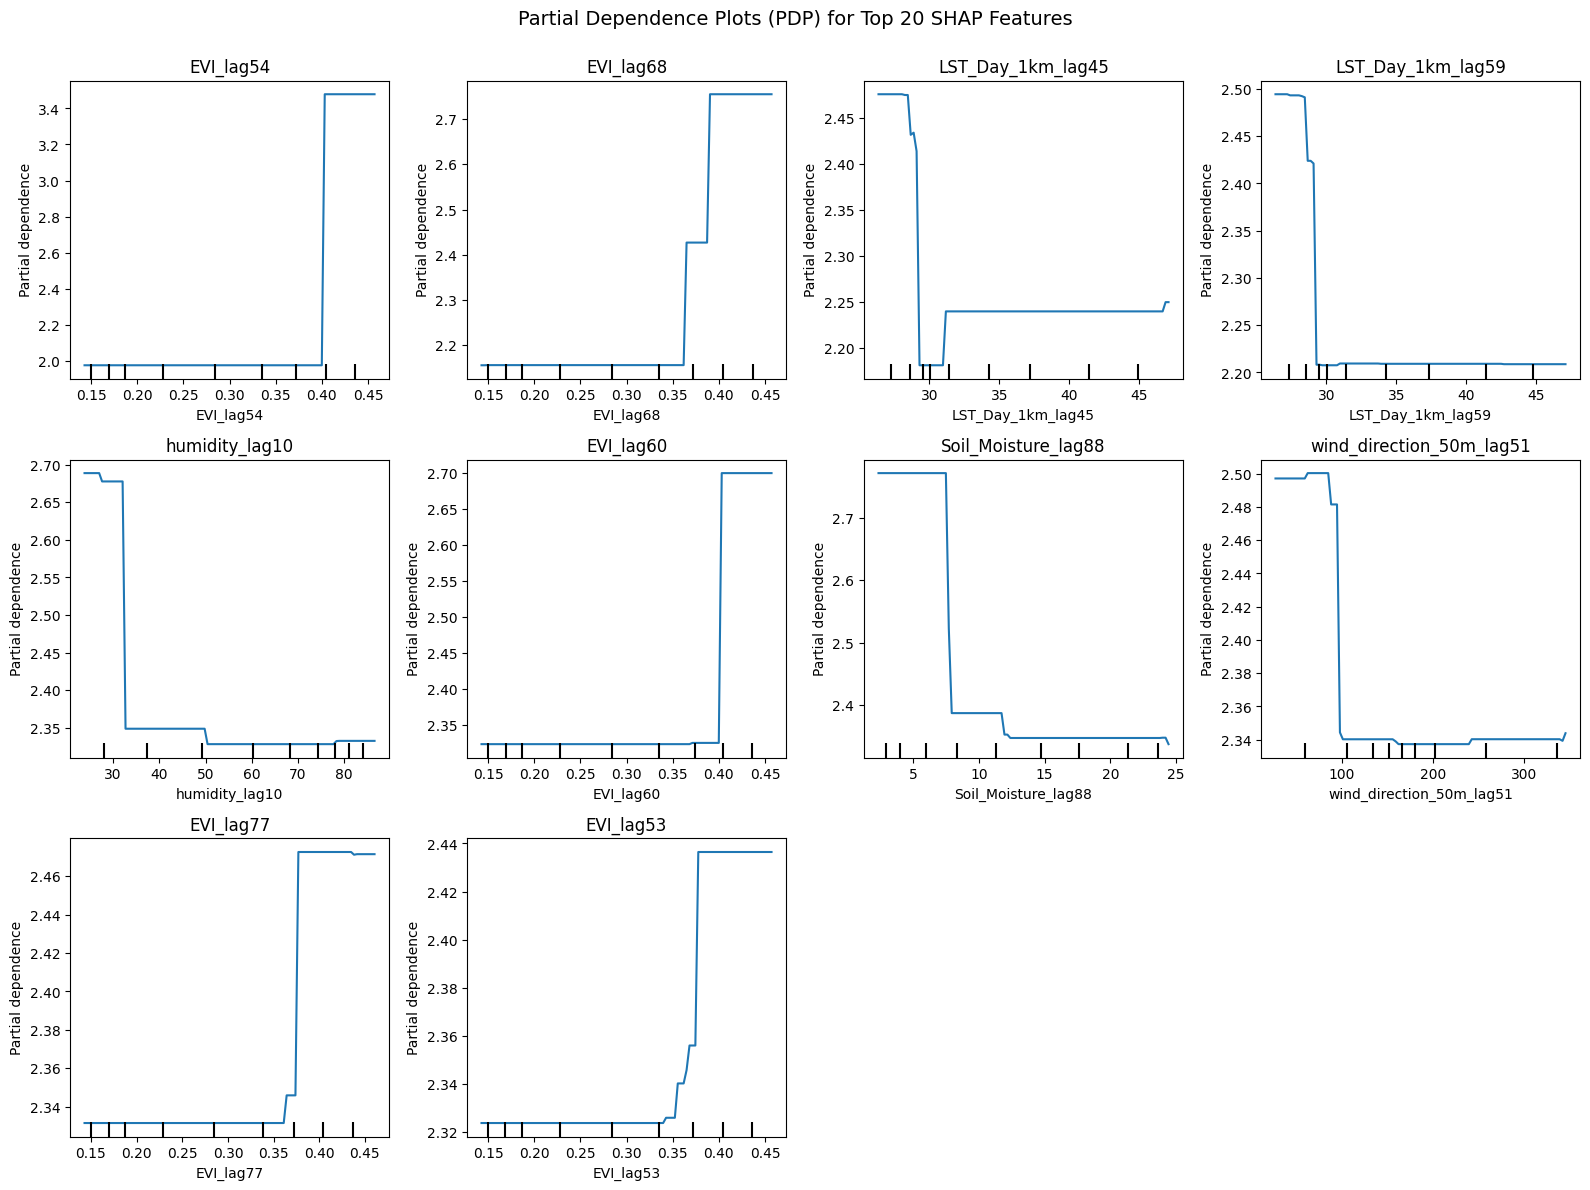

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.inspection import PartialDependenceDisplay

# Compute SHAP values
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_train)

# Get mean absolute SHAP values for each feature
shap_importance = np.abs(shap_values.values).mean(axis=0)

# Create a DataFrame to store SHAP importance
shap_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'SHAP_Importance': shap_importance
})

# Sort by SHAP importance and select the top 20 features
top_10_features = shap_importance_df.sort_values(by='SHAP_Importance', ascending=False).head(10)['Feature'].values

# Define grid layout (5 rows × 4 columns)
n_cols = 4
n_rows = (len(top_20_features) + n_cols - 1) // n_cols  # Ensure all features fit

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))  # Adjust figure size dynamically
axes = axes.flatten()  # Flatten to easily iterate over subplots

# Generate PDP plots for the top 20 SHAP-selected features
for i, feature in enumerate(top_10_features):
    pdp_display = PartialDependenceDisplay.from_estimator(best_xgb, X_train, features=[feature], ax=axes[i])
    axes[i].set_title(feature, fontsize=12)
    axes[i].set_xlabel(feature, fontsize=10)  # Set x-axis label

# Remove unused subplots (if top features < total grid size)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Partial Dependence Plots (PDP) for Top 20 SHAP Features", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])  # Adjust layout to fit title
plt.show()


### Interpretation of Partial Dependence Plots (PDPs) for Leishmaniasis Predictors

These PDPs show how changes in EVI (vegetation index), LST (land surface temperature), Soil Moisture, and Humidity influence the predicted number of Leishmaniasis cases, while keeping other factors constant.

#### 1️⃣ EVI (Enhanced Vegetation Index - Lag 54)
📈 Sharp Increase at ~0.4

At low EVI values (below ~0.4), the predicted number of cases is stable.

Once EVI exceeds ~0.4, cases increase significantly, suggesting that high vegetation cover promotes sandfly breeding and disease transmission.

This aligns with Leishmania vector preference for dense vegetation.

#### 2️⃣ LST (Land Surface Temperature - Lag 59)
📉 Decreasing trend at ~30°C and stabilizes

Cases slightly decrease as LST increases from ~30°C onward.

This suggests that Leishmaniasis transmission may be limited at very high temperatures (possibly due to sandfly survival constraints).

Stable impact beyond a certain LST threshold.

#### 3️⃣ Soil Moisture (Lag 88)
📉 Drop in cases at low soil moisture (~5), then stabilizes

Cases are initially high at low soil moisture (~5), but then drop and stabilize beyond this point.

This indicates that sandflies may require some, but not excessive, moisture for survival.

Extreme dryness or excessive wetness may not favor transmission.

#### 4️⃣ Humidity (Lag 10)
📉 Higher humidity slightly reduces risk

Higher humidity reduces Leishmaniasis risk up to a threshold, then stabilizes.

This could mean sandflies thrive better in moderately dry conditions, but extreme humidity may limit their activity.

# 2D  PDP (Interactions)

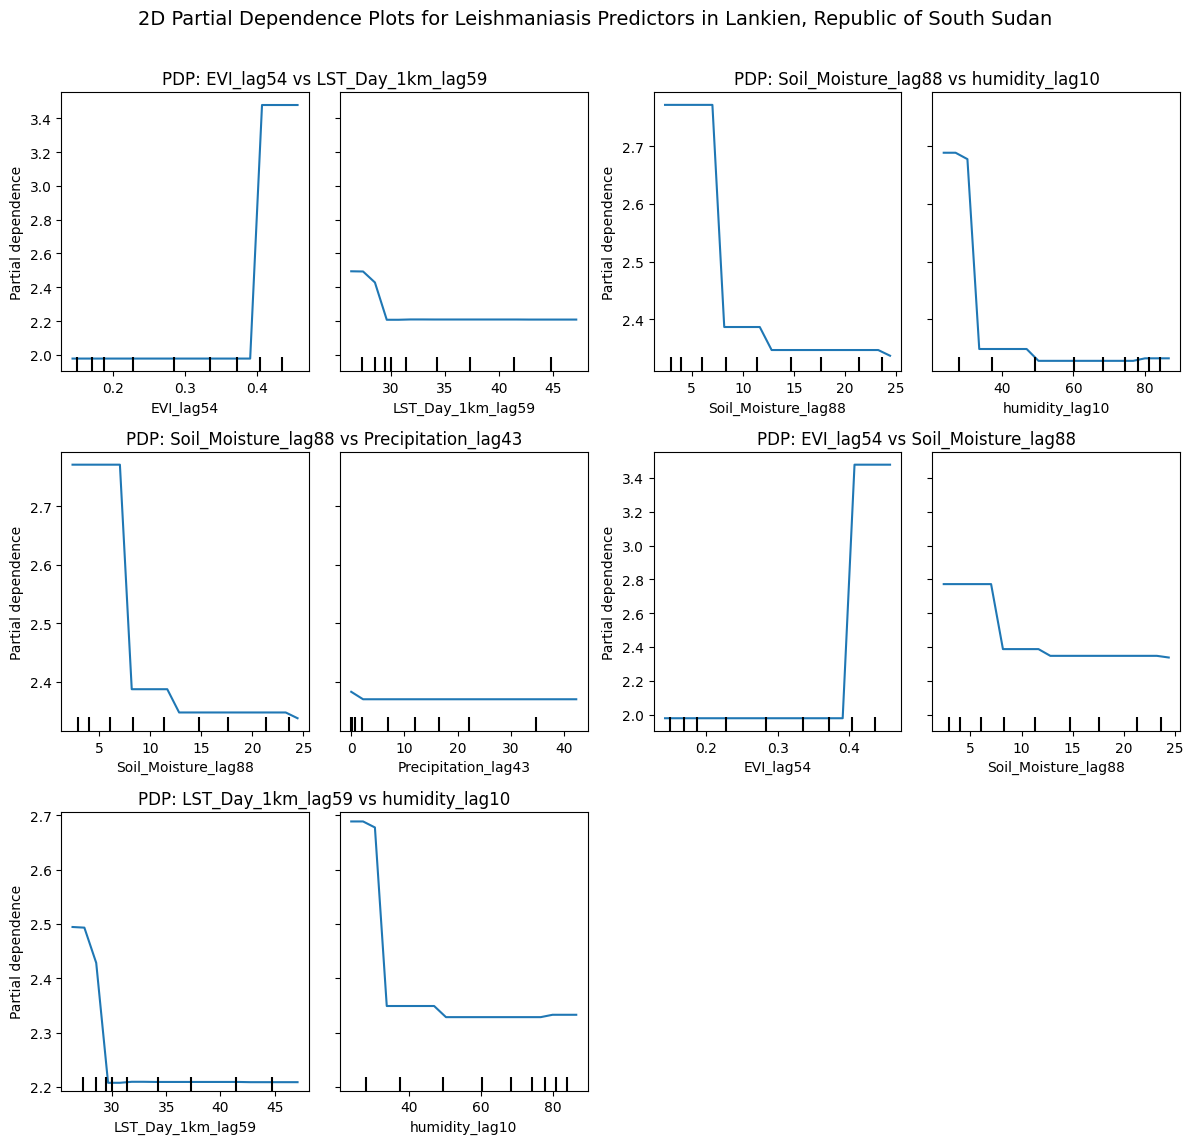

In [51]:
import matplotlib.pyplot as plt
import shap
from sklearn.inspection import PartialDependenceDisplay

# Assuming 'best_xgb' is your trained model and 'X_train' is the training dataset

# Selecting the top interacting features for 2D PDP
features_to_plot = [
    ("EVI_lag54", "LST_Day_1km_lag59"),
    ("Soil_Moisture_lag88", "humidity_lag10"),
    ("Soil_Moisture_lag88", "Precipitation_lag43"),
    ("EVI_lag54", "Soil_Moisture_lag88"),
    ("LST_Day_1km_lag59", "humidity_lag10")
]

# Define grid layout dynamically (3 rows x 2 columns to fit 5 plots)
n_cols = 2
n_rows = (len(features_to_plot) + n_cols - 1) // n_cols  # Compute required rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))  
axes = axes.flatten()  # Flatten to iterate easily

# Generate 2D PDP plots
for i, (feat1, feat2) in enumerate(features_to_plot):
    pdp_display = PartialDependenceDisplay.from_estimator(
        best_xgb, X_train, features=[feat1, feat2], ax=axes[i], grid_resolution=20
    )
    axes[i].set_title(f"PDP: {feat1} vs {feat2}", fontsize=12)
    axes[i].set_xlabel(feat1, fontsize=10)  # X-axis label
    axes[i].set_ylabel(feat2, fontsize=10)  # Y-axis label

# Remove any unused subplots if features_to_plot < grid size
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("2D Partial Dependence Plots for Leishmaniasis Predictors in Lankien, Republic of South Sudan", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout for better spacing
plt.show()


# Actual versus predicted cases   

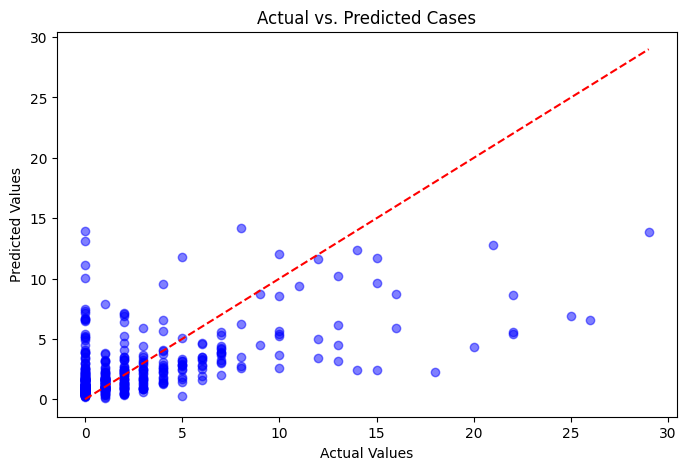

In [52]:
# Plotting Actual vs Predicted Cases
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Line of perfect prediction
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Cases")
plt.show()


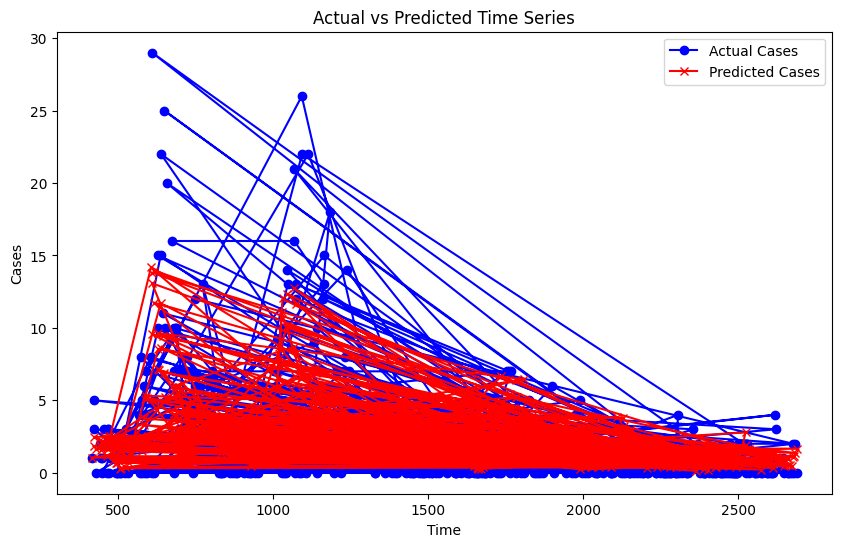

In [53]:
# Plotting Actual vs Predicted Time Series
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Cases', color='blue', linestyle='-', marker='o')
plt.plot(y_test.index, y_pred_xgb, label='Predicted Cases', color='red', linestyle='-', marker='x')
plt.xlabel("Time")
plt.ylabel("Cases")
plt.title("Actual vs Predicted Time Series")
plt.legend()
plt.show()
